# Project Ideas

You may want to consider one or more of the following types of questions when developing your submission.

1. For either city, how do incidents vary by time of day? Which incidents are most common in the evening? During what periods of the day are robberies most common?

2. For either city, how do incidents vary by neighborhood? Which incidents are most common in the city center? In what areas or neighborhoods are robberies or thefts most common?

3. For either city, how do incidents vary month to month in the Summer 2014 dataset?

4. For either city, which incident types tend to correlate with each other on a day-by-day basis?

5. Advanced:

    A. Advanced What can we infer broadly about the differences in crime patterns between Seattle and San Francisco? Does one city tend to have more crime than the other, per capita? Do the relative frequencies of types of incidents change materially between the two cities? (NOTE: The two datasets do not have the same schema, so comparisons will require some work and some assumptions. This will require extra work, but you will be working at the forefront of what is known!)

    B. Advanced For either city, do certain crimes correlate with environmental factors such as temperature? (To answer this kind of question, you will need to identify and use external data sources!)

# Load incidents data for Seattle and San Francisco

In [263]:
import csv
def load_data(data_file_csv):
    data_dict = {'rows':[]} 
    with open (data_file_csv, "r") as data_file:
        reader = csv.DictReader(data_file)
        data_dict['header'] = reader.fieldnames
        for row in reader:
            data_dict['rows'].append(row)
    return data_dict

In [264]:
seattle_is14_data_csv = 'seattle_incidents_summer_2014.csv'  
sanfrancisco_is14_data_csv = 'sanfrancisco_incidents_summer_2014.csv'
# Loading data
seattle_is14_data = load_data(seattle_is14_data_csv)
sanfrancisco_is14_data = load_data(sanfrancisco_is14_data_csv)

In [265]:
print seattle_is14_data['header']
print sanfrancisco_is14_data['header']

['RMS CDW ID', 'General Offense Number', 'Offense Code', 'Offense Code Extension', 'Offense Type', 'Summary Offense Code', 'Summarized Offense Description', 'Date Reported', 'Occurred Date or Date Range Start', 'Occurred Date Range End', 'Hundred Block Location', 'District/Sector', 'Zone/Beat', 'Census Tract 2000', 'Longitude', 'Latitude', 'Location', 'Month', 'Year']
['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId']


In [266]:
# For Seattle how do incidents vary by time of day?

from dateutil.parser import parse # for parsing date

incidents_per_day_hour = {}
hours_by_incident = {}

for incident in seattle_is14_data['rows']:
    # print incident['Date Reported'], incident['Offense Type'], incident['Offense Code Extension'], 
    # parse( incident['Date Reported']).hour
    hour = parse( incident['Date Reported']).hour
    incident_type = incident['Offense Type']
    
    if incident_type not in hours_by_incident:
        hours_by_incident[incident_type]= {'by_hour':{hour:1}}
    else:
        hours_by_incident[incident_type]['by_hour'][hour] = hours_by_incident[incident_type]['by_hour'].get(hour, 0) + 1 

    if hour not in incidents_per_day_hour:
        incidents_per_day_hour[hour] = { 'by_type':{incident_type:1}}
    else:
        incidents_per_day_hour[hour]['by_type'][incident_type] = incidents_per_day_hour[hour]['by_type'].get(incident_type, 0) + 1 

In [267]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pie_hour_top_incident(hours, top_k = 5):
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'white']
    #explode = (0.1, 0, 0, 0, 0)
    f, axarr = plt.subplots(len(hours), sharey=True, figsize=(5*len(hours),5*len(hours)))
    for h_idx, hour in enumerate(hours):
        sorted_by_freq = sorted([(item, freq) for item, freq in incident_per_day_hour[hour]['by_type'].iteritems()],
                                key= lambda x: x[1], reverse= True)  
        axarr[h_idx].pie([item[1] for item in sorted_by_freq][:top_k], labels=[item[0] for item in sorted_by_freq][:top_k], colors=colors, 
                        #explode=explode, 
                         autopct='%1.1f%%', shadow=True, startangle=90)        
        axarr[h_idx].set_title('top '+ str(top_k) + ' incidents from '+ datetime.strptime(str(hour), "%H").strftime("%I %p") +' to '+ datetime.strptime(str(hour+1), "%H").strftime("%I %p"))
        axarr[h_idx].axis('equal')

## TOP K Incidents distribution by day hour for Seattle
Relative distribution of the top k incidents given an hour shows that CARPROWL is the most probable incident in Seattle, here the graphics represente hours from 12 pm to 3 am, neverthless the Car prowl keeps the first position with clear difference during all the day. (CARPROWL seams to be popular crime)

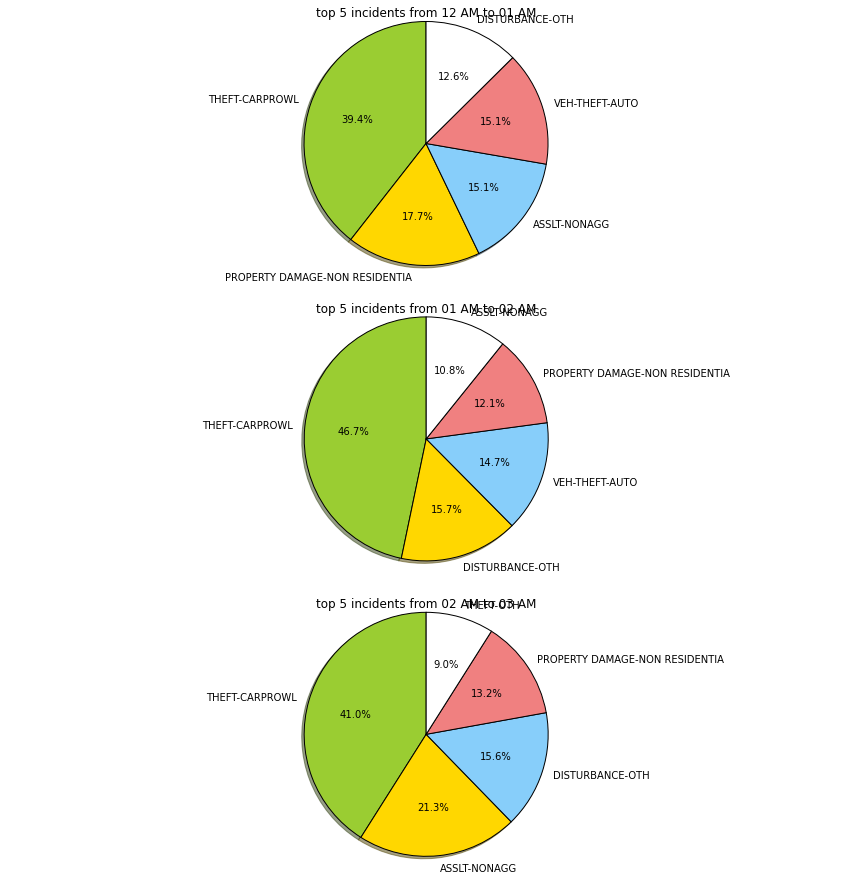

In [268]:
plot_pie_hour_top_incident([0,1,2])

In [269]:
# Extraction of categories for clearer graphics
categs = set()
for incident in hours_by_incident:
    if incident.lower().startswith('robbery'):
        # Extract categories only for robbery
        for categ in incident.split('-')[1:]:
            categs.add(categ)
categs = list(categs)
print categs


['BUSINESS', 'RESIDENCE', 'WEAPON', 'BODYFORCE', 'GUN', 'STREET', 'BANK']


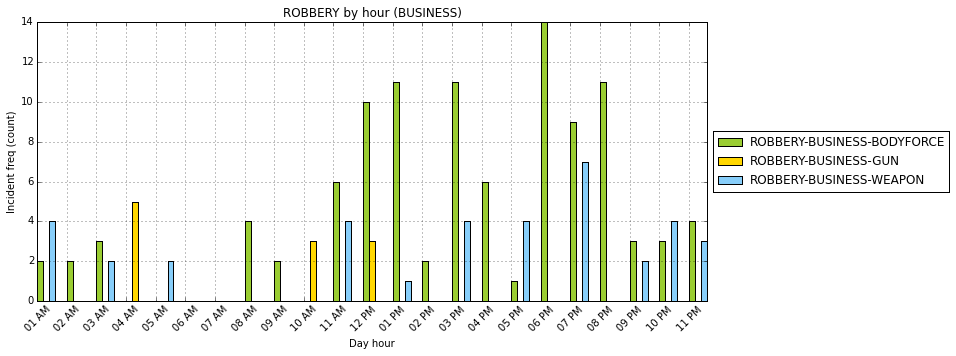

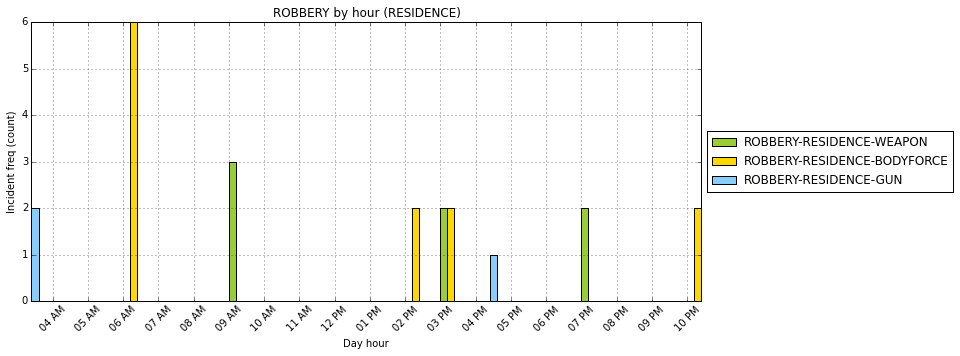

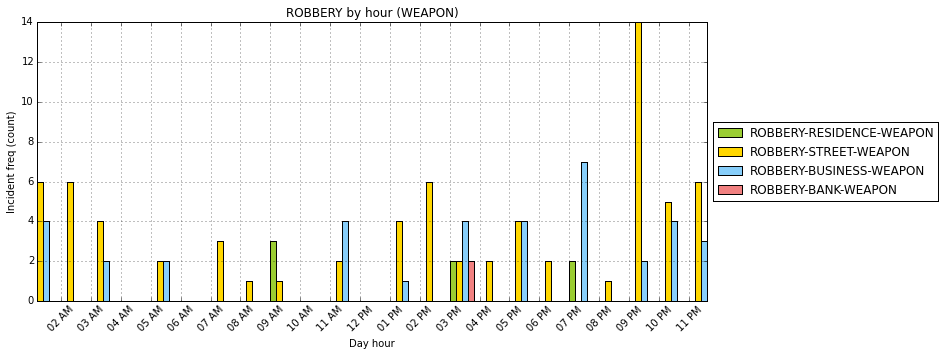

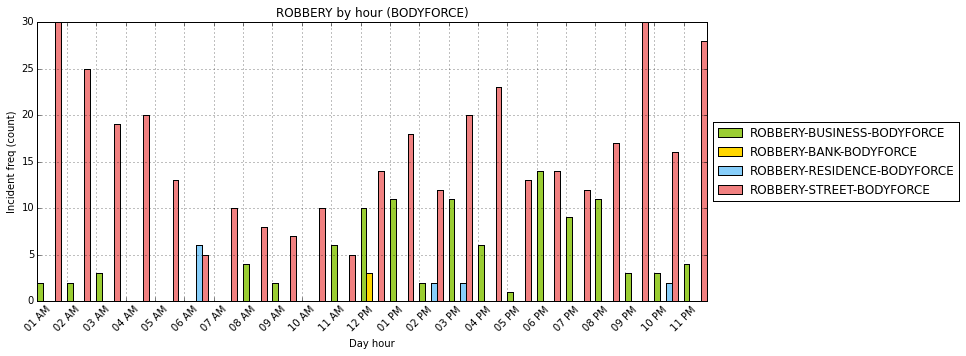

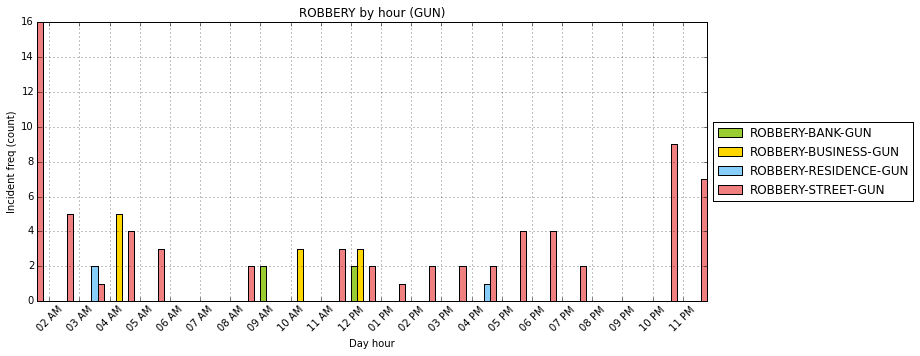

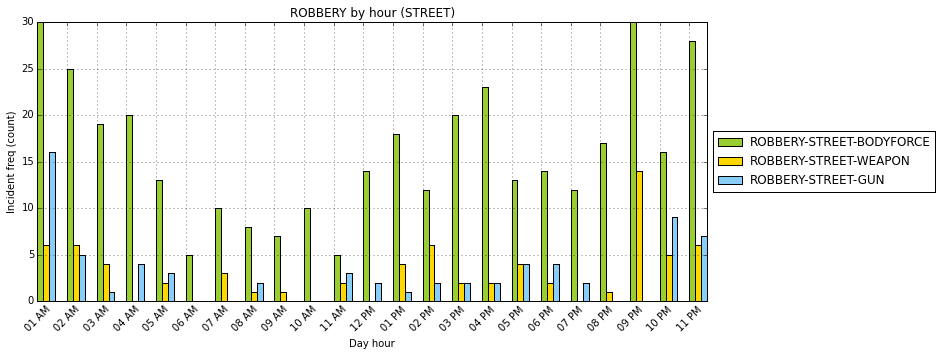

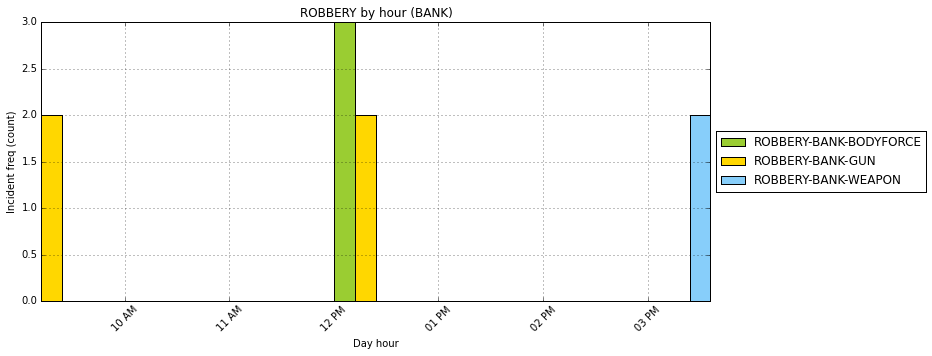

In [270]:
#from datetime import datetime
#
#f, ax = plt.subplots(figsize=(12,5))
#ax.set_title('Incident by hour')
#ax.set_xlabel('Day hour')
#ax.set_ylabel('Incident freq (count)')
        
#for incident, data in  hours_by_incident.iteritems():
#    if incident.lower().startswith('robbery') :# and 'bank'  in incident.lower():        
#        ax.set_xticks(range(24))
#        ax.set_xticklabels([datetime.strptime(str(h), "%H").strftime("%I %p") for h in range(24)], rotation=45  )
#        x, y = zip(* sorted ([(hour, count) for hour, count in data['by_hour'].iteritems()], key = lambda x : x[0]))
#        ax.plot(x,y, marker='o', linestyle='--', label = incident)
#        ax.grid()
#        #ax.hold(True)
#        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#        #f.grid()


import numpy as np
# plot by categ 
def robbery_plot(categ):
    assert categ in categs
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'white']
    f, ax = plt.subplots(figsize=(12,5))
    ax.set_title('ROBBERY by hour ('+categ+')')
    ax.set_xlabel('Day hour')
    ax.set_ylabel('Incident freq (count)')
    ax.set_xticks(range(24))  
    ax.set_xticklabels([datetime.strptime(str(h), "%H").strftime("%I %p") for h in range(24)], rotation=45  )
    ax.grid()
    idx = 0
    for incident, data in  hours_by_incident.iteritems():
        labels_by_level =  incident.split('-')
        
        if labels_by_level[0] == 'ROBBERY'  and categ in labels_by_level[1:]:
            #print labels_by_level
            width = 0.2
            x, y = zip(* sorted ([(hour, count) for hour, count in data['by_hour'].iteritems() if count and hour], key = lambda x : x[0]))
            x= list(x)
            y= list(y)
            #ax.plot(x,y, marker='o', linestyle='--', label = incident)
            ax.bar(np.array(x)+ idx*width,y, width= width, label = incident, color = colors[idx])
            idx += 1
            
            #ax.hold(True)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #f.grid()

for categ in categs:
    robbery_plot(categ)

1. Bank robbery
interestingly Bank robbery are more likely to happen during the middle of the day while the Gun Robbery is equally distributed between day and night. Robbery with weapon (maybe heavier than guns) are more likely to happen during night while during the day the bodyforce is more probable 

2. Gun is more used for street Robbery which has a pic at night between 12 AM and 1 AM ...

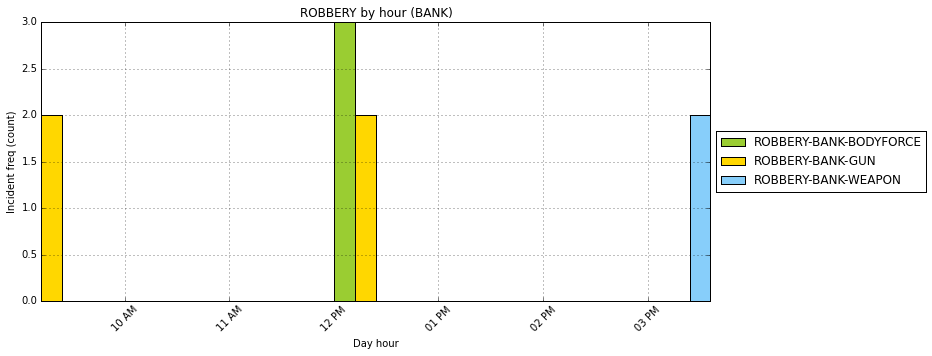

In [271]:
robbery_plot('BANK')

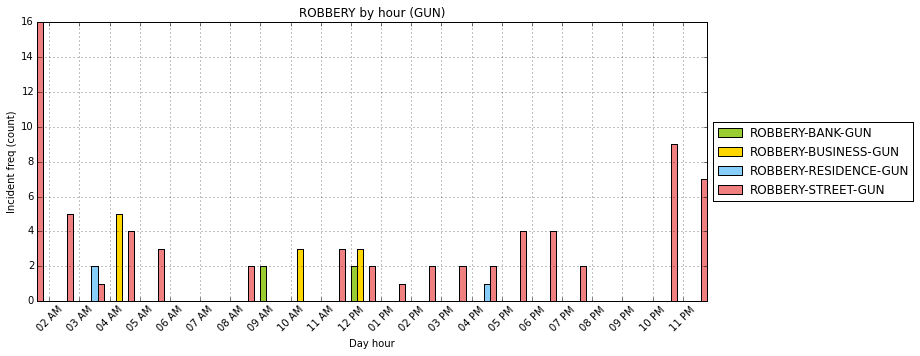

In [272]:
robbery_plot('GUN')

The bodyforce is clearly more used for STREET ROBBERY 

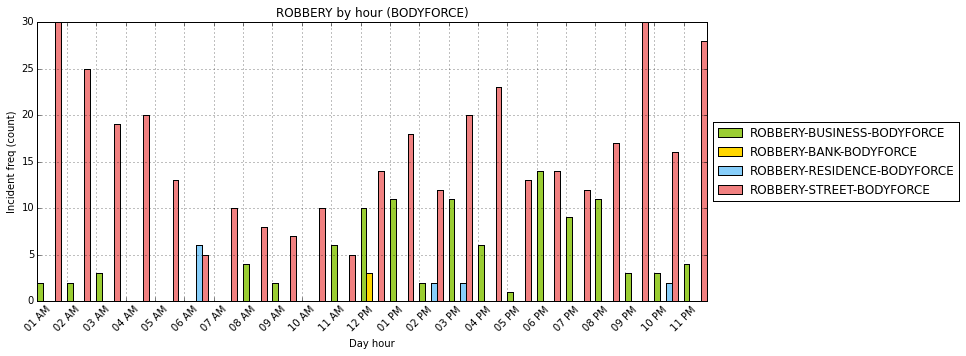

In [273]:
robbery_plot('BODYFORCE')

# Incidents by neighborhood

In [274]:
incident_nbr_by_zone = {}
for incident in seattle_is14_data['rows']:
    incident_nbr_by_zone[incident ['Zone/Beat']] = incident_nbr_by_zone.get(incident ['Zone/Beat'], 0) + 1
print incident_nbr_by_zone
# to be continued 

{'Q1': 530, '': 56, 'Q3': 653, 'Q2': 622, 'S3': 514, 'S2': 588, 'S1': 505, 'U1': 776, 'U3': 579, 'U2': 805, 'K3': 773, 'K2': 841, 'K1': 765, 'M1': 837, 'M3': 968, 'M2': 837, 'O3': 346, 'O2': 370, 'O1': 365, 'W2': 432, 'G3': 440, 'G2': 525, 'G1': 429, 'C3': 456, 'C2': 642, 'C1': 582, 'E1': 645, 'W1': 491, 'E3': 521, 'E2': 1089, 'R1': 668, 'R2': 606, 'R3': 567, '99': 40, 'L2': 692, 'L3': 587, 'L1': 703, 'N1': 777, 'N2': 743, 'N3': 813, 'F1': 468, 'F2': 539, 'F3': 588, 'J1': 752, 'J2': 711, 'J3': 741, 'W3': 401, 'B1': 681, 'B2': 845, 'B3': 812, 'D2': 700, 'D3': 592, 'D1': 771}


# Incident month to month in the Summer 2014 dataset

In [275]:
# to be continued 